# Objective

Demonstrate how noise is generated in CMB-ML. Verify a white (flat) noise power spectrum.

# Imports and Parameters

In [1]:
from pathlib import Path

import numpy as np
import healpy as hp
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

from handle_data import get_map_dtype, get_planck_obs_data

In [2]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"

DETECTOR = 100
RANDOM_SEED = 42

In [3]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

# Display PS Helper Function

In [4]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

# Creating a Noise Map at $N_{side}=2048$

We first generate noise as used in CMB-ML for a full resolution map.

In [5]:
# Get Planck's official observation data, set Nside
obs_map_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)
use_nside_out = 2048

File /data/jim/CMB_Data/Assets/Planck/HFI_SkyMap_100_2048_R3.01_full.fits exists.


In [6]:
# Load the source map from Planck
planck_obs_path = Path(ASSETS_DIRECTORY) / obs_map_fn
II_cov_field = 4
II_cov_map = hp.read_map(planck_obs_path, hdu=1, field=II_cov_field)

assert use_nside_out == hp.get_nside(II_cov_map)  # Make sure we're using the right nside

In [7]:
# Create a "scale factor" map for the noise
scale_map = np.sqrt(II_cov_map)  # II_cov_map contains variance values; we need standard deviation for rng.normal()
scale_map = scale_map * 1e6  # convert to uK_CMB

In [8]:
# Generate the random noise map; calculate its power spectrum
rng = np.random.default_rng(RANDOM_SEED)
wht_map_2048 = rng.normal(scale=scale_map)

lmax_2048 = get_lmax_for_nside(use_nside_out)  # Defined above as 3*Nside-1
ells_2048 = np.arange(lmax_2048 + 1)
wht_cl_2048 = hp.anafast(wht_map_2048, lmax=lmax_2048)

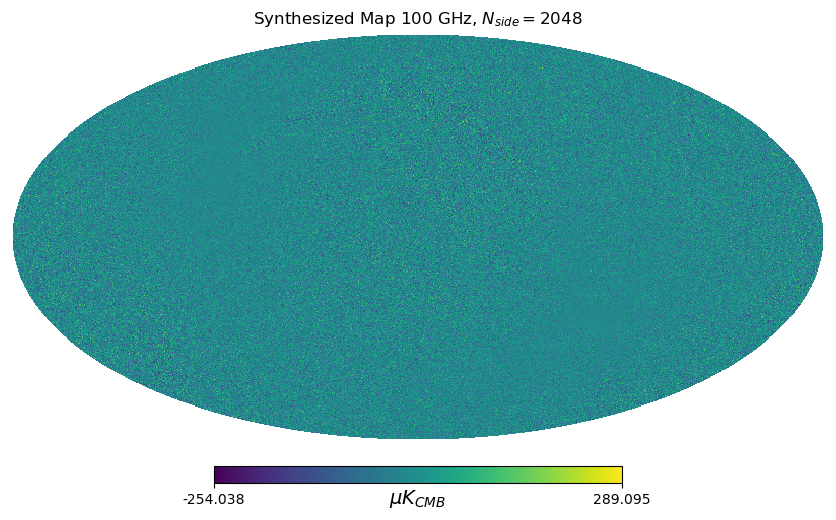

In [9]:
hp.mollview(wht_map_2048, unit="$\\mu K_{CMB}$", 
            title="Synthesized Map" + f" {DETECTOR} GHz, " + "$N_{side}" + f"={use_nside_out}$")

In [10]:
assert hp.npix2nside(wht_map_2048.shape[0]) == 2048
print(f"We confirm that the map is resolution {hp.npix2nside(wht_map_2048.shape[0])}")

We confirm that the map is resolution 2048


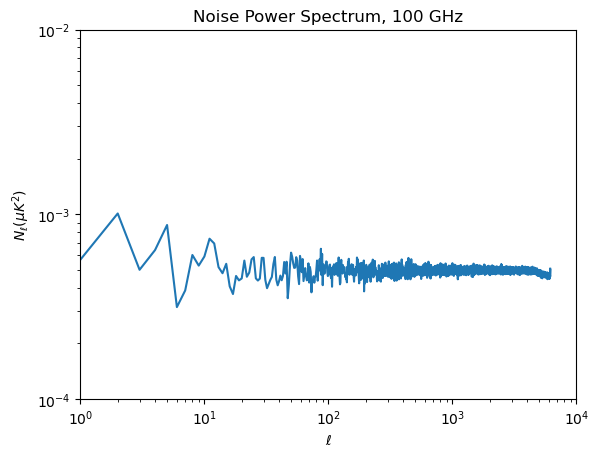

In [11]:
# Add the white noise level line to the plot; see if it matches expectations
plot_ps(wht_cl_2048, title=f"Noise Power Spectrum, {DETECTOR} GHz")

It looks like white noise at roughly 1e-4 $\mu K^2$.

# Creating a Noise Map at $N_{side}=512$

We now repeat the procedure at the downgraded resolution.

In [12]:
use_nside_out = 512

In [13]:
def _change_variance_map_resolution(m, nside_out):
    # For variance maps, because statistics
    power = 2

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion
    
    return m

In [14]:
II_cov_map_512 = _change_variance_map_resolution(II_cov_map, use_nside_out)
scale_map = np.sqrt(II_cov_map_512) * 1e6  # convert to uK_CMB

rng = np.random.default_rng(RANDOM_SEED)
var_map_512 = rng.normal(scale=scale_map)

lmax_512 = get_lmax_for_nside(use_nside_out)  # Defined above as 3*Nside-1
ells_512 = np.arange(lmax_512 + 1)
var_map_cl_512 = hp.anafast(var_map_512, lmax=lmax_512)

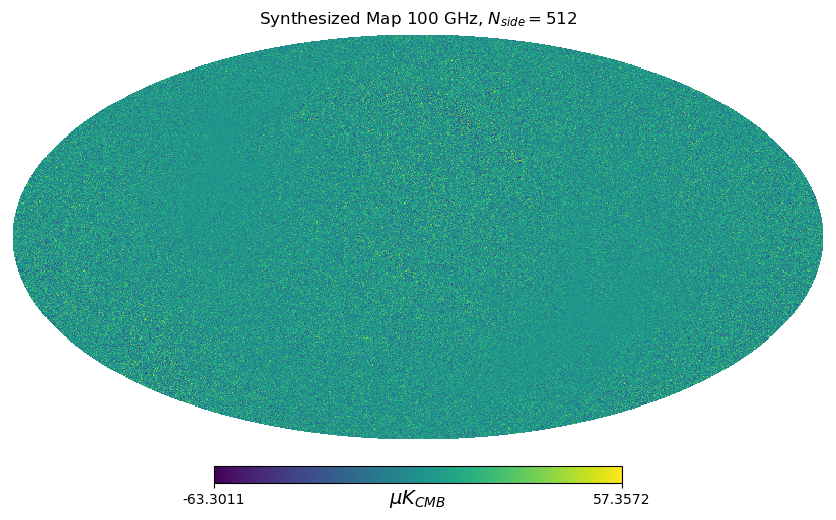

In [15]:
hp.mollview(var_map_512, unit="$\\mu K_{CMB}$", 
            title="Synthesized Map" + f" {DETECTOR} GHz, " + "$N_{side}" + f"={use_nside_out}$")

In [16]:
assert hp.npix2nside(var_map_512.shape[0]) == 512
print(f"We confirmed that the map is resolution {hp.npix2nside(var_map_512.shape[0])}")

We confirmed that the map is resolution 512


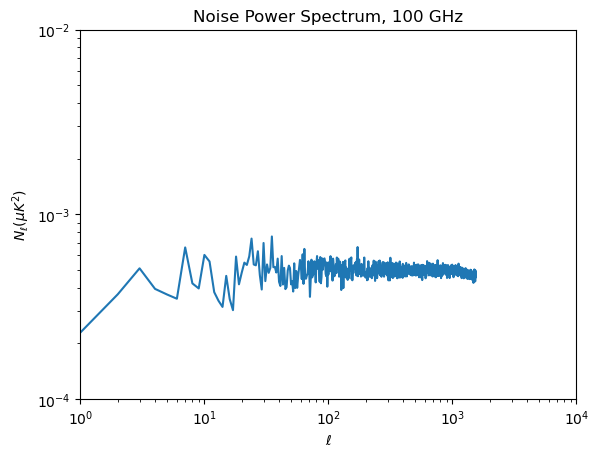

In [17]:
plot_ps(var_map_cl_512, title=f"Noise Power Spectrum, {DETECTOR} GHz")

It still looks like white noise at roughly 1e-4 $\mu K^2$; this matches what we saw for 2048. This is expected.

# Comparing results after downgrade

How do I know that the noise generated this way is done properly? If the power spectra match, I don't think there's a way to make the histograms "match" (in a way which is immediately obvious). But I tried it, so it's staying here for now.

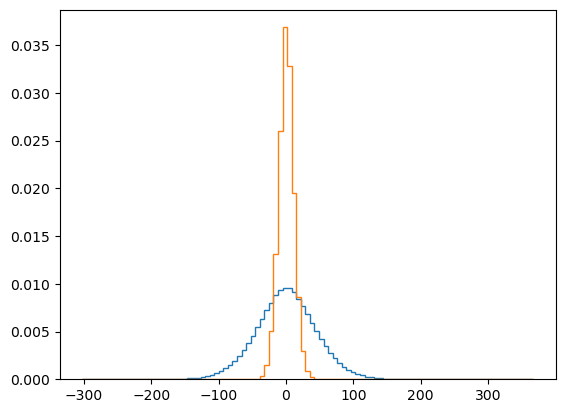

In [18]:
min_val = min(wht_map_2048.min(), var_map_512.min())
max_val = max(wht_map_2048.max(), var_map_512.max())
bins = np.linspace(min_val, max_val, 100)

plt.hist(wht_map_2048.flatten(), bins=bins, density=True, histtype='step')
plt.hist(var_map_512.flatten(), bins=bins, density=True, histtype='step');

We see a mismatch. I'm going to confirm this is the case in the CMB-ML library.

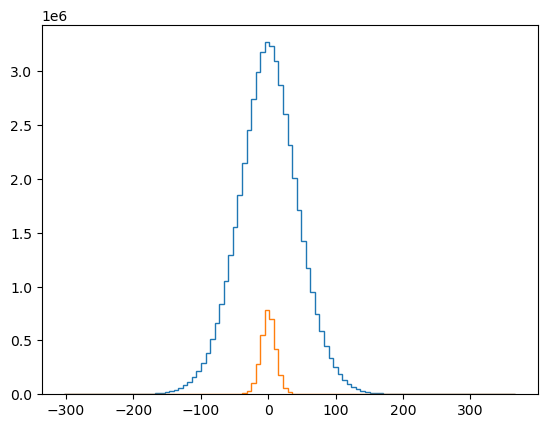

In [19]:
min_val = min(wht_map_2048.min(), var_map_512.min())
max_val = max(wht_map_2048.max(), var_map_512.max())
bins = np.linspace(min_val, max_val, 100)

plt.hist(wht_map_2048.flatten(), bins=bins, density=False, histtype='step')
plt.hist(var_map_512.flatten(), bins=bins, density=False, histtype='step');

In [20]:
statistic, p_value = ks_2samp(wht_map_2048.flatten(), var_map_512.flatten())

print("Statistic:", statistic)
print("P-value:", p_value)

Statistic: 0.28061942259470624
P-value: 0.0


In [21]:
# Check to see that the KS test works as expected
data1 = np.random.normal(0, 2, wht_map_2048.shape[0])
data2 = np.random.normal(0, 2, var_map_512.shape[0])

statistic, p_value = ks_2samp(data1, data2)

print("Statistic:", statistic)
print("P-value:", p_value)

Statistic: 0.000470737616221073
P-value: 0.5278356816978358


Clearly, the distributions are different. I'm not sure there's a trivial way to verify that this is being done correctly.